# LightGBM

## Install & Import Packages

In [ ]:
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 95.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt

## Load Files

In [ ]:
df = r"submission_sample.csv"
df = pd.read_csv(df)
df.head()

,srch_id,prop_id
0,1,3180
1,1,5543
2,1,14142
3,1,22393
4,1,24194


In [ ]:
train = r"train_data_v3.csv"
df_train = pd.read_csv(train)
df_train.head()

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,srch_id_price_median,srch_id_price_std,prop_review_score_mean,price_per_star,historical_price_diff,avg_comp_rate_diff,comp_price_diff,weighted_review_score,price_to_quality,session_impressions
0,1,12,187,0.0,0.0,219,893,0.0,-0.5,1,...,0.260545,0.941664,-0.5,-0.188654,-0.190101,0.00,-0.171414,-0.382226,-0.099163,-0.428571
1,1,12,187,0.0,0.0,219,10404,1.0,0.0,1,...,0.260545,0.941664,0.0,0.099777,0.475455,0.00,0.494949,0.393833,0.181472,-0.428571
2,1,12,187,0.0,0.0,219,21315,0.0,0.5,1,...,0.260545,0.941664,0.5,0.740741,0.568081,0.00,0.586465,0.296232,0.312442,-0.428571
3,1,12,187,0.0,0.0,219,27348,-1.0,0.0,1,...,0.260545,0.941664,0.0,9.713304,4.845859,-2.25,4.881616,-0.606167,6.481511,-0.428571
4,1,12,187,0.0,0.0,219,29604,1.0,-0.5,1,...,0.260545,0.941664,-0.5,-0.152546,0.202121,0.00,0.220606,0.000000,0.122668,-0.428571


In [ ]:
df_train[df_train['price_usd']>5000].count()

srch_id                        184
site_id                        184
visitor_location_country_id    184
visitor_hist_starrating        184
visitor_hist_adr_usd           184
                              ... 
avg_comp_rate_diff             184
comp_price_diff                184
weighted_review_score          184
price_to_quality               184
session_impressions            184
Length: 110, dtype: int64

In [ ]:
test = r"test_data_v3.csv"
df_test = pd.read_csv(test)
df_test.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,srch_id_price_median,srch_id_price_std,prop_review_score_mean,price_per_star,historical_price_diff,avg_comp_rate_diff,comp_price_diff,weighted_review_score,price_to_quality,session_impressions
0,1,2013-02-02 15:27:40,24,216,-0.02,-0.85,219,3180,0.0,0.5,...,-0.471113,-0.307204,0.5,-0.012387,-0.047172,0.00,-0.027677,0.296232,-0.242502,-0.285714
1,1,2013-02-02 15:27:40,24,216,-0.02,-0.85,219,5543,0.0,0.5,...,-0.471113,-0.307204,0.5,-0.024774,-0.056263,0.00,-0.037778,0.296232,-0.251629,-0.285714
2,1,2013-02-02 15:27:40,24,216,-0.02,-0.85,219,14142,-1.0,-0.5,...,-0.471113,-0.307204,-0.5,-0.575994,-0.745455,-0.25,-0.732222,-0.875000,-0.603059,-0.285714
3,1,2013-02-02 15:27:40,24,216,-0.02,-0.85,219,22393,0.0,0.5,...,-0.471113,-0.307204,0.5,0.284900,0.195253,0.00,0.214747,0.296232,-0.023445,-0.285714
4,1,2013-02-02 15:27:40,24,216,-0.02,-0.85,219,24194,0.0,0.5,...,-0.471113,-0.307204,0.5,-0.507866,-0.448081,0.00,-0.431717,0.296232,-0.607596,-0.285714


## Generate Submission Dataframe

In [ ]:
def create_submission(model1, model2, Test_data, proba = False):
    import time
    start = time.time()
    
    Test = Test_data
    #predictions
    print("~ Making predictions")
    if proba == True:
        clickpreds = model1.predict_proba(Test.drop(['srch_id','prop_id'], axis = 1))
        bookpreds = model2.predict_proba(Test.drop(['srch_id','prop_id'], axis = 1))
        
        Test['click_preds'] = pd.DataFrame(clickpreds)[1].values
        Test['booking_preds'] = pd.DataFrame(bookpreds)[1].values
    else:
        clickpreds = model1.predict(Test.drop(['srch_id','prop_id'], axis = 1))
        bookpreds = model2.predict(Test.drop(['srch_id','prop_id'], axis = 1))
    
        Test['click_preds'] = clickpreds
        Test['booking_preds'] = bookpreds
    
    #Grab 4 columns from Test
    sub = Test[['srch_id','prop_id','click_preds','booking_preds']]
    #Weight booking column values
    
    if proba == True:
        sub['booking_preds'] = sub['booking_preds'].apply(lambda x: x*2 if x > 0 else x)
    else:
        sub['booking_preds'] = sub['booking_preds'].apply(lambda x: x+1 if x > 0 else x)
    #Total click & booking values, remove columns
    sub['total'] = sub['click_preds']+sub['booking_preds']
    sub.drop(['click_preds', 'booking_preds'], axis = 1, inplace = True)
    
    #Sort chunks of srch ids by 'total' value
    print(f"~ Sorting chunks of srch_ids: {(time.time()-start):.2f}s have passed")
    ids = sub['srch_id'].unique()
    sub1 = pd.DataFrame()
    k=0
    
    srch_id = []
    prop_id = []
    total = []
    for item in ids:
       
        df = sub[sub['srch_id'] == item].sort_values('total', ascending = False)
        srch_id.append(df['srch_id'].values)
        prop_id.append(df['prop_id'].values)
        total.append(df['total'].values)
    
        k+=1
        if not k%10000:
            print(f"{k}/{len(ids)} srch_ids, time elapsed: {(time.time() - start):.2f}s")

    #Unpack list of arrays
    print(f"~ Unpacking lists: {(time.time() - start):.2f}s elapsed")
    _srch_id = []
    for i in range(0,len(srch_id)):
        for k in range(0,len(srch_id[i])):
            _srch_id.append(srch_id[i][k])
    _prop_id = []
    for i in range(0,len(prop_id)):
        for k in range(0,len(prop_id[i])):
            _prop_id.append(prop_id[i][k])
    _total = []
    for i in range(0,len(total)):
        for k in range(0,len(total[i])):
            _total.append(total[i][k])
    
    #Create Dataframe from unpacked lists
    print(f"~ Creating Dataframe: {(time.time() - start):.2f}s elapsed")
    sub2 = pd.DataFrame(zip(_srch_id, _prop_id, _total),
               columns =['srch_id', 'prop_id','total'])
    
    sub1 = sub2[['srch_id','prop_id']]
    
    print(f"~ Finished. Total time: {(time.time() - start):.2f}")
    return(sub1, sub2)
    

## Remove Variables & Initialize the Model

#List of variables to keep
variables_to_keep = [
    "site_id",
    "visitor_location_country_id",
    "prop_country_id",
    "prop_review_score",
    "prop_location_score1",
    "prop_location_score2",
    "prop_log_historical_price",
    "price_usd",
    "srch_destination_id",
    "srch_booking_window",
    "orig_destination_distance",
    "srch_length_of_stay",
    "srch_adults_count"
]

# Dropping all other variables
X_train = df_train[variables_to_keep]

Y1_train = df_train['click_bool']
Y2_train = df_train['booking_bool']

In [ ]:
#List of variables to keep
variables_to_keep = [
    "prop_country_id",
    "prop_review_score",
    "prop_location_score1",
    "prop_location_score2",
    "prop_log_historical_price",
    "price_usd"
]

# Dropping all other variables
X_train = df_train[variables_to_keep]



Y1_train = df_train['click_bool']
Y2_train = df_train['booking_bool']


#X_train = df_train.drop(['srch_id', 'prop_id','click_bool', 'booking_bool'], axis = 1)

#"Data-Time" is dropped since it is "object" format
#X_train = X_train.drop(['date_time'], axis=1)

#9 additional features with minimal impact are dropped so that the model works 
#X_train = X_train.drop(['is_weekend','comp7_rate_percent_diff','comp7_inv','comp7_rate','comp6_rate','comp5_inv','comp2_inv', 'comp3_rate','comp6_rate_percent_diff'], axis=1)

#Delete Additional features 
#X_train = X_train.drop(['date_time'], axis=1)

#Y1_train = df_train['click_bool']
#Y2_train = df_train['booking_bool']

In [ ]:
import pandas as pd

print(X_train.shape)
print(df_test.shape)
print(X_train.columns)
print(df_test.columns)

(4958347, 6)
(4959183, 106)
Index(['prop_country_id', 'prop_review_score', 'prop_location_score1',
       'prop_location_score2', 'prop_log_historical_price', 'price_usd'],
      dtype='object')
Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score',
       ...
       'srch_id_price_median', 'srch_id_price_std', 'prop_review_score_mean',
       'price_per_star', 'historical_price_diff', 'avg_comp_rate_diff',
       'comp_price_diff', 'weighted_review_score', 'price_to_quality',
       'session_impressions'],
      dtype='object', length=106)


In [ ]:
print(X_train.dtypes)
print(df_test.dtypes)


prop_country_id                int64
prop_review_score            float64
prop_location_score1         float64
prop_location_score2         float64
prop_log_historical_price    float64
price_usd                    float64
dtype: object
srch_id                          int64
date_time                       object
site_id                          int64
visitor_location_country_id      int64
visitor_hist_starrating        float64
                                ...   
avg_comp_rate_diff             float64
comp_price_diff                float64
weighted_review_score          float64
price_to_quality               float64
session_impressions            float64
Length: 106, dtype: object


In [ ]:
LGBMclick = lgb.LGBMClassifier(scale_pos_weight = 12, n_estimators = 76)
LGBMbook = lgb.LGBMClassifier(scale_pos_weight = 12, n_estimators = 78)

# Parameter Tuning

#from lightgbm import LGBMClassifier
#from sklearn.model_selection import GridSearchCV

#param_grid = {
    'num_leaves': [31, 61, 91],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 10, 20],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.6, 0.8, 1.0]
#}

#lgbm = LGBMClassifier()
#grid_search = GridSearchCV(lgbm, param_grid, scoring='roc_auc', cv=5)
#grid_search.fit(X_train, Y1_train)

#print(f"Best parameters for click model: {grid_search.best_params_}")

#grid_search.fit(X_train, Y2_train)
#print(f"Best parameters for booking model: {grid_search.best_params_}")

## Training the Model

In [ ]:
LGBMclick.fit(X_train, Y1_train)
LGBMbook.fit(X_train, Y2_train)

[LightGBM] [Info] Number of positive: 221879, number of negative: 4736468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1139
[LightGBM] [Info] Number of data points in the train set: 4958347, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.044749 -> initscore=-3.060915
[LightGBM] [Info] Start training from score -3.060915
[LightGBM] [Info] Number of positive: 138390, number of negative: 4819957
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1139
[LightGBM] [Info] Number of data points in the train set: 4958347, number of used features: 6
[LightGBM]

LGBMClassifier(n_estimators=78, scale_pos_weight=12)

## Check Importance of Features

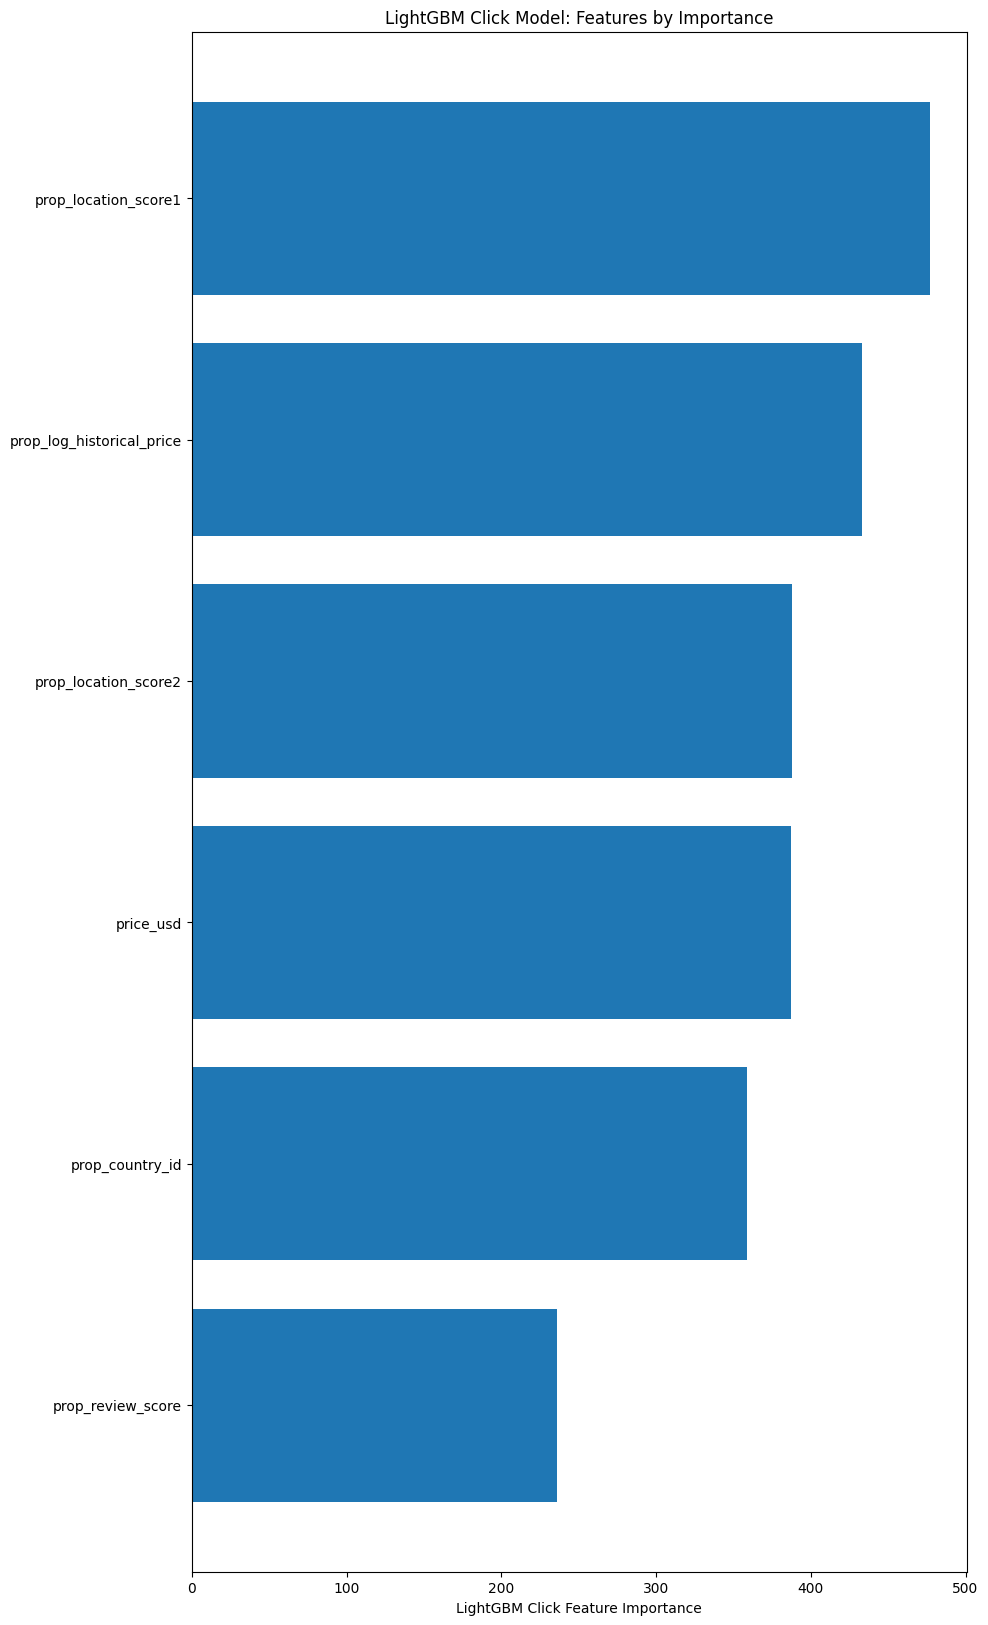

In [ ]:
import matplotlib.pyplot as plt

#Set the size of the plot
plt.figure(figsize=(10, 20))  # Width, Height in inches

#Sorting the indices of the features by importance
sorted_idx = LGBMclick.feature_importances_.argsort()

#Create a horizontal bar plot
plt.barh(X_train.columns[sorted_idx], LGBMclick.feature_importances_[sorted_idx])
plt.xlabel("LightGBM Click Feature Importance")
plt.title("LightGBM Click Model: Features by Importance")

#Show the plot
plt.show()


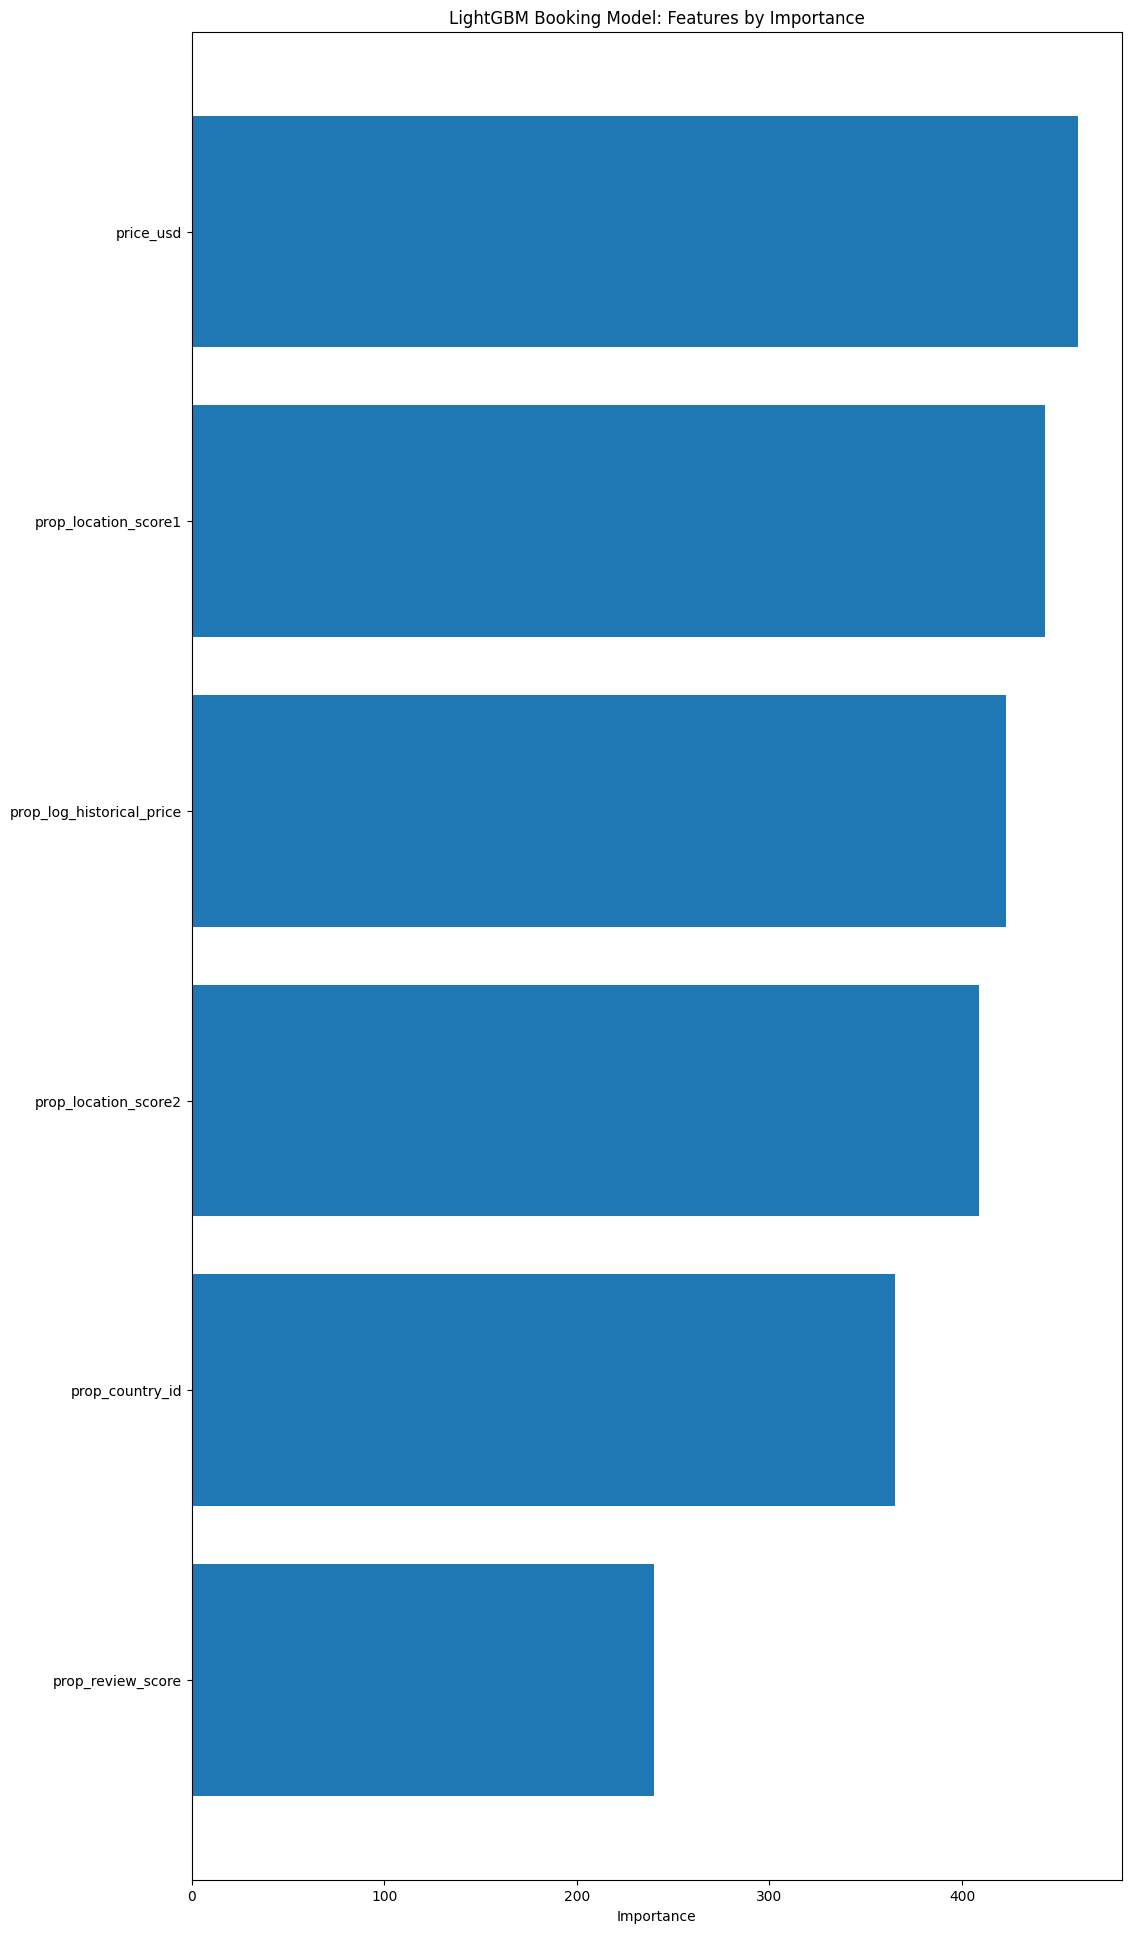

In [ ]:
import matplotlib.pyplot as plt

#Set the size of the plot
plt.figure(figsize=(12, 24))  #Adjust the width and height to suit your display needs

#Sorting the indices of the features by importance
sorted_idx = LGBMbook.feature_importances_.argsort()

#Create a horizontal bar plot
plt.barh(X_train.columns[sorted_idx], LGBMbook.feature_importances_[sorted_idx])
plt.xlabel("Importance")
plt.title("LightGBM Booking Model: Features by Importance")

#Show the plot
plt.show()


In [ ]:
# Check for any missing or additional columns in df_test
print("Missing in df_test:", set(X_train.columns) - set(df_test.columns))
print("Extra in df_test:", set(df_test.columns) - set(X_train.columns))


Missing in df_test: set()
Extra in df_test: {'visitor_hist_starrating_missing', 'comp6_rate', 'is_weekend', 'comp8_inv', 'price_rank', 'comp5_inv', 'month', 'prop_review_score_missing', 'srch_adults_count', 'day', 'srch_children_count', 'srch_id_price_std', 'historical_price_diff', 'price_to_quality', 'session_impressions', 'comp4_rate_missing', 'visitor_location_country_id', 'srch_id', 'comp2_rate_percent_diff_missing', 'srch_saturday_night_bool', 'weighted_review_score', 'srch_destination_id', 'comp8_rate_percent_diff_missing', 'comp6_rate_missing', 'comp5_rate_percent_diff', 'srch_room_count', 'comp2_rate_missing', 'comp1_rate_missing', 'date_time', 'comp3_inv_missing', 'comp3_rate_percent_diff', 'year', 'srch_booking_window', 'prop_location_score2_missing', 'comp7_rate', 'srch_query_affinity_score_missing', 'orig_destination_distance_missing', 'comp1_inv', 'comp_price_diff', 'prop_review_score_mean', 'price_diff_from_median', 'destination_search_count', 'comp7_inv', 'comp6_inv', 'c

In [ ]:
print(X_train.shape)
print(df_test.shape)
print(X_train.columns)
print(df_test.columns)

(4958347, 6)
(4959183, 106)
Index(['prop_country_id', 'prop_review_score', 'prop_location_score1',
       'prop_location_score2', 'prop_log_historical_price', 'price_usd'],
      dtype='object')
Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score',
       ...
       'srch_id_price_median', 'srch_id_price_std', 'prop_review_score_mean',
       'price_per_star', 'historical_price_diff', 'avg_comp_rate_diff',
       'comp_price_diff', 'weighted_review_score', 'price_to_quality',
       'session_impressions'],
      dtype='object', length=106)


## Testing the Model & Creating Submission File 

In [ ]:
#df_test = df_test.drop('date_time', axis=1)

# List of variables to keep
test_variables_to_keep = [
    "srch_id",
    "site_id",
    "visitor_location_country_id",
    "prop_country_id",
    "prop_id",
    "prop_review_score",
    "prop_location_score1",
    "prop_location_score2",
    "prop_log_historical_price",
    "price_usd",
    "srch_destination_id",
    "srch_booking_window",
    "orig_destination_distance",
    "srch_length_of_stay",
    "srch_adults_count"
]

# Dropping all other variables
df_test = df_test[test_variables_to_keep]

In [ ]:
# List of variables to keep
test_variables_to_keep = [
    "srch_id",
    "prop_country_id",
    "prop_id",
    "prop_review_score",
    "prop_location_score1",
    "prop_location_score2",
    "prop_log_historical_price",
    "price_usd"
]

# Dropping all other variables
df_test = df_test[test_variables_to_keep]


In [ ]:
results = create_submission(LGBMclick,LGBMbook,df_test, proba = True)

~ Making predictions
/tmp/ipykernel_219/3380218670.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['booking_preds'] = sub['booking_preds'].apply(lambda x: x*2 if x > 0 else x)
/tmp/ipykernel_219/3380218670.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['total'] = sub['click_preds']+sub['booking_preds']
/tmp/ipykernel_219/3380218670.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

In [ ]:
results[1]

,srch_id,prop_id,total
0,1,99484,1.736692
1,1,28181,1.647839
2,1,54937,1.647195
3,1,24194,1.444647
4,1,61934,1.365514
...,...,...,...
4959178,332787,32019,1.012598
4959179,332787,29018,0.997266
4959180,332787,99509,0.946647
4959181,332787,35240,0.810209


In [ ]:
results[0]

,srch_id,prop_id
0,1,99484
1,1,28181
2,1,54937
3,1,24194
4,1,61934
...,...,...
4959178,332787,32019
4959179,332787,29018
4959180,332787,99509
4959181,332787,35240


In [ ]:
results[0].to_csv('Kaggle_Submission.csv',index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e2c4d580-0670-4443-9265-5d094bb23253' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>